Título do Trabalho:Análise de Imagens Citológicas com SVM e Transfer Learning

Descrição: Neste trabalho será desenvolvido um sistema de apoio ao diagnóstico para detetar metástases em gânglios linfáticos de pacientes com cancro da mama, com recurso a imagens citológicas e dados suplementares do dataset SLN-Breast.

Serão aplicados métodos de Machine Learning (ML), nomeadamente:

Support Vector Machine (SVM)
Redes Neuronais clássicas (NN)
Adicionalmente, será explorado um método de Deep learning(DL) com recurso a Transfer Learning (TL), recorrendo a modelos pré-treinados para extrair características das imagens de patologia.

Os modelos serão avaliados com métricas como exatidão, precisão, sensibilidade e matriz de confusão, comparando o desempenho entre abordagens clássicas e baseadas em deep learning.

In [18]:
#Importação de bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openslide #para carregar os ficheiros .svs
import os
from PIL import Image
from tqdm import tqdm  # barra de progresso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


Carregamento e visualização do DataSet

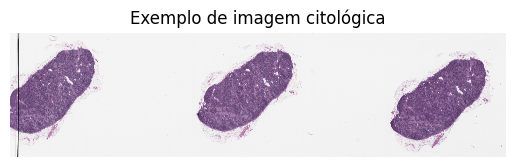

In [2]:
#carregar e visualizar as imagens 

# Caminho para a pasta onde estão os ficheiros .svs
image_folder = "/Volumes/PHILIPS_UFD/SLN-Breast"
image_files = os.listdir(image_folder)

# Aumentar o limite de pixels para evitar o erro DecompressionBombError
Image.MAX_IMAGE_PIXELS = None

#Carregar e mostrar uma imagem de exemplo
img_path = os.path.join(image_folder, image_files[0])
img = Image.open(img_path)

plt.imshow(img)
plt.title("Exemplo de imagem citológica")
plt.axis('off')
plt.show()

In [4]:
# Carregar dados suplementares
df = pd.read_csv("/Volumes/PHILIPS_UFD/PKG-SLN-Breast/target.csv")

# Visualizar as primeiras linhas
print(df.head())

# Verificar distribuição das classes
print(df['target'].value_counts())

                     slide  target
0  HobI16-053768896760.svs       1
1  HobI16-072823783181.svs       1
2  HobI16-105105202254.svs       0
3  HobI16-303757967057.svs       0
4  HobI16-334188031493.svs       0
target
0    94
1    36
Name: count, dtype: int64


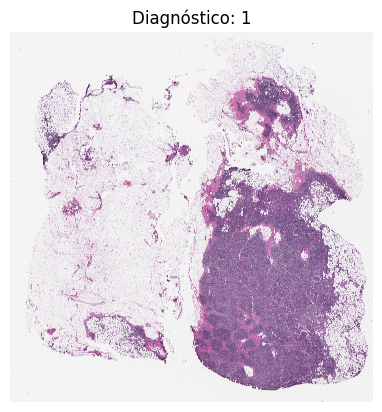

In [5]:
#Combinar as imagens com os dados do CSV
# Exemplo: carregar uma imagem com base no nome no CSV
sample = df.iloc[0]
img_path = os.path.join(image_folder, sample['slide'])
img = Image.open(img_path)

plt.imshow(img)
plt.title(f"Diagnóstico: {sample['target']}")
plt.axis('off')
plt.show()


Pré-processamento

O que é que está ser feito e porquê?  Extraímos uma parte da imagem com área de 1000x1000 em vez da imagem completa com zoom 0 (maior resolução) e depois é redimensionado para 224x224 pois é a dimensão que alguns modelos de deep learning esperam. Assim o redimensionamento garente compatibilidade com os modelos. Apesar de poder haver perda de detalhe, permite treinar os modelos de forma mais rápida exigindo menos poder de computação. Existe um compromisso entre a capacidade de computação e preservação da informação. Caso o modelo não tenha uma boa performance ajustamos este redimensionamento. A normalização serve para colocar os valores dos píxeis entre 0.0 e 1.0 para melhorar a eficiência do treino e estabilidade numérica do modelo.

In [6]:
# ---  Pré-processar cada imagem ---
# Lista final com dados
data = []

# Iterar sobre as imagens indicadas no CSV
for file in tqdm(df["slide"]):
    file_path = os.path.join(image_folder, file)

    try:
        slide = openslide.OpenSlide(file_path)

        # Extrair uma região (1000x1000 no nível 0)
        region = slide.read_region((0, 0), 0, (1000, 1000)).convert("RGB")

        # Redimensionar e normalizar
        resized = region.resize((224, 224))
        array = np.array(resized) / 255.0

        # Obter o rótulo correspondente
        label = df[df["slide"] == file]["target"].values[0]

        data.append((array, label))

    except Exception as e:
        print(f"[ERRO] {file}: {e}")

# Separar arrays
X = np.array([d[0] for d in data])
y = np.array([d[1] for d in data])

print("Shape das imagens:", X.shape)
print("Shape dos rótulos:", y.shape)


Python(2601) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 130/130 [00:43<00:00,  3.01it/s]

Shape das imagens: (130, 224, 224, 3)
Shape dos rótulos: (130,)


Modelos de ML (Machine Learning)

1) SVM

In [ ]:
# Separar treino e teste
X_flat = X.reshape(X.shape[0], -1)  # Flatten as imagens para SVM
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42) #20% dos dados para teste

# SVM
svm = SVC(kernel='linear', probability=True) #usa fronteira de decisão linear
svm.fit(X_train, y_train) #treino do modelo
y_pred = svm.predict(X_test) #teste do modelo

Acurácia do modelo: 0.7692
Relatório de Classificação:
                precision    recall  f1-score   support

Sem Metástase       0.79      0.95      0.86        20
Com Metástase       0.50      0.17      0.25         6

     accuracy                           0.77        26
    macro avg       0.65      0.56      0.56        26
 weighted avg       0.72      0.77      0.72        26



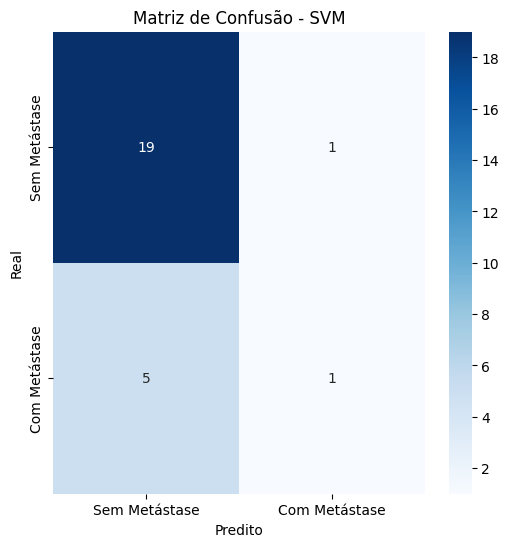

In [10]:
# Avaliar o desempenho do modelo
acc = accuracy_score(y_test, y_pred)  # Acurácia
print(f"Acurácia do modelo: {acc:.4f}")

# Relatório de classificação (precisão, recall, F1-score)
class_report = classification_report(y_test, y_pred, target_names=['Sem Metástase', 'Com Metástase'])
print("Relatório de Classificação:\n", class_report)

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot da Matriz de Confusão
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sem Metástase', 'Com Metástase'], yticklabels=['Sem Metástase', 'Com Metástase'])
plt.title('Matriz de Confusão - SVM')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

2) Neural Network

In [52]:
# Normalizar os dados antes do PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar PCA (ex: 50 componentes)
pca = PCA(n_components=70)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
# Etapa 1: Criar o classificador MLP
mlp = MLPClassifier(max_iter=500, random_state=42)

# Etapa 2: Definir o grid de hiperparâmetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (10, 10)],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant']
}



# Etapa 3: Pesquisa em grelha com validação cruzada (5-fold)
grid_search = GridSearchCV(mlp, param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=500, random_state=42),
             param_grid={'activation': ['logistic', 'relu'],
                         'hidden_layer_sizes': [(100,), (100,), (10, 10)],
                         'learning_rate': ['constant'],
                         'solver': ['sgd', 'adam']})

In [58]:
# Etapa 4: Resultados
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

# Etapa 5: Previsões no teste
y_pred = best_model.predict(X_test_pca)
y_prob = best_model.predict_proba(X_test_pca)[:, 1]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

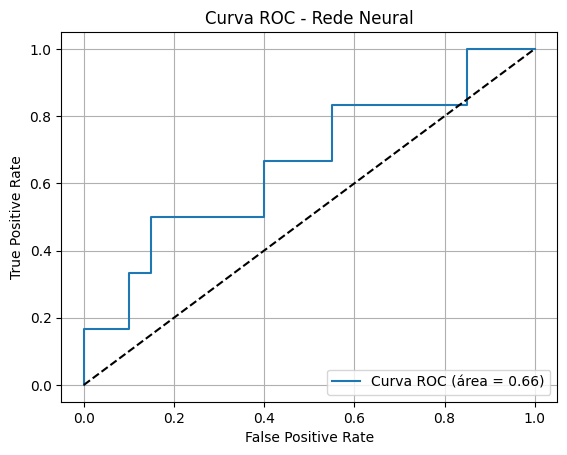

In [59]:
# Etapa 6: Relatório e matriz

report = classification_report(y_test, y_pred, target_names=["Sem Metástase", "Com Metástase"])
matrix = confusion_matrix(y_test, y_pred)

# Etapa 7: Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Probabilidades da classe positiva (metástase)
y_prob = best_model.predict_proba(X_test_pca)[:, 1]

# Calcular curva ROC e AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # linha diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Rede Neural')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

               precision    recall  f1-score   support

Sem Metástase       0.77      1.00      0.87        20
Com Metástase       0.00      0.00      0.00         6

     accuracy                           0.77        26
    macro avg       0.38      0.50      0.43        26
 weighted avg       0.59      0.77      0.67        26



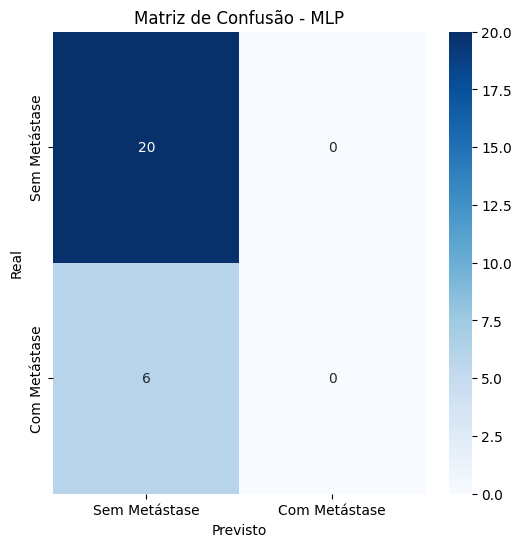

In [60]:
# Fazer previsões com o modelo MLP
y_pred = best_model.predict(X_test_pca)

# Gerar matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Imprimir relatório de classificação
print(classification_report(y_test, y_pred, target_names=["Sem Metástase", "Com Metástase"]))

# Plotar a matriz de confusão
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Sem Metástase", "Com Metástase"],
            yticklabels=["Sem Metástase", "Com Metástase"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - MLP")
plt.show()